## Weather Data : Initial Visualization

### For New York State

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

# import findspark
# findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [4]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [5]:
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

%mkdir -p $data_dir
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ../Data/Weather/NY.tgz

-rw-r--r--  1 timothytyree  staff    63M May  2 14:29 ../Data/Weather/NY.tgz


In [6]:
!ls $data_dir

NY.parquet         STAT_NY.pickle     US_stations.tsv.gz
NY.tgz             STAT_NY.pickle.gz


In [7]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

/Users/timothytyree/Documents/GitHub/Public-DSC291/notebooks/Section2-PCA/Data/Weather
155648	./NY.parquet
/Users/timothytyree/Documents/GitHub/Public-DSC291/notebooks/Section2-PCA/Section2-Weather-PCA_PART1


In [8]:
!du -h $data_dir/$parquet

 76M	../Data/Weather/NY.parquet


In [9]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".

NY.parquet


In [10]:
%%time
weather_df.count()

CPU times: user 808 µs, sys: 1.49 ms, total: 2.3 ms
Wall time: 907 ms


168398

In [11]:
print('number of rows=',weather_df.cache().count())
weather_df.show(5)

number of rows= 168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.7133026123046

### read statistics information for state.

In [32]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz



In [ ]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath

In [ ]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))
print('keys from STAT=',STAT.keys())

In [13]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [16]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz



In [19]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/Users/timothytyree/Documents/GitHub/Public-DSC291/notebooks/Section2-PCA/Data/Weather
155648	NY.parquet
832	stations.parquet
/Users/timothytyree/Documents/GitHub/Public-DSC291/notebooks/Section2-PCA/Section2-Weather-PCA_PART1


In [20]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [21]:
weather_df=weather_df#.drop('name').drop('dist_coast')
weather_df.show(3)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+---

In [22]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(3)
jdf.columns

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.

['Station',
 'Measurement',
 'Year',
 'Values',
 'dist_coast',
 'latitude',
 'longitude',
 'elevation',
 'state',
 'name',
 'Dist_coast',
 'Latitude',
 'Longitude',
 'Elevation',
 'State',
 'Name']

In [23]:
sqlContext.registerDataFrameAsTable(weather_df,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select name,count(name) as count from jdf group by name order by count desc').show(5)
#GROUP BY name ORDER BY count').show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [24]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  120|
|       TMIN|  120|
|   SNOW_s20|  121|
|       TOBS|  113|
|   SNWD_s20|  109|
|   TOBS_s20|  113|
|   PRCP_s20|  121|
|       TMAX|  120|
|       SNOW|  121|
|   TMAX_s20|  120|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [25]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1919|   12|
|1936|   12|
|1950|   12|
|1951|   12|
|1983|   12|
+----+-----+
only showing top 5 rows



In [26]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,dist_coast,latitude,longitude,elevation,state,name
Measurement,,,,,,,,,
SNOW_s20,USC00302610,2007,"[102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD_s20,USC00302610,2007,"[170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TOBS_s20,USC00302610,2007,"[85, 203, 22, 204, 135, 204, 255, 204, 123, 20...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP_s20,USC00302610,2007,"[25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMAX_s20,USC00302610,2007,"[79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMIN_s20,USC00302610,2007,"[85, 209, 139, 209, 195, 209, 253, 209, 59, 21...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA


## Plots

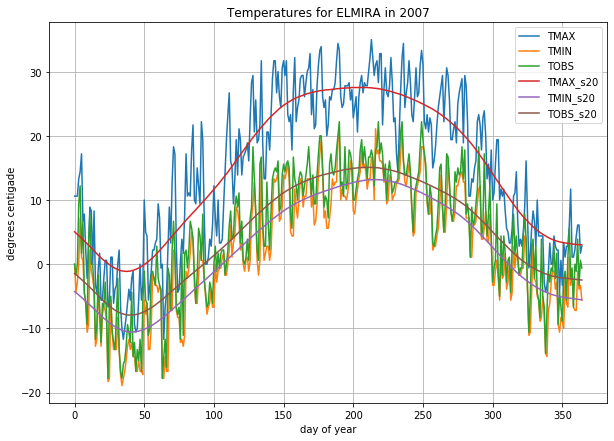

In [27]:
_tmax_20=unpackArray(pandas_df.loc['TMAX_s20','Values'],np.float16)/10.
_tmin_20=unpackArray(pandas_df.loc['TMIN_s20','Values'],np.float16)/10.
_tobs_20=unpackArray(pandas_df.loc['TOBS_s20','Values'],np.float16)/10.
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.float16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.float16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.float16)/10.
figure(figsize=_figsize)
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');

plot(_tmax_20,label='TMAX_s20');
plot(_tmin_20,label='TMIN_s20');
plot(_tobs_20,label='TOBS_s20');
xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(stat,year))
legend()
grid()

### Script for plotting yearly plots

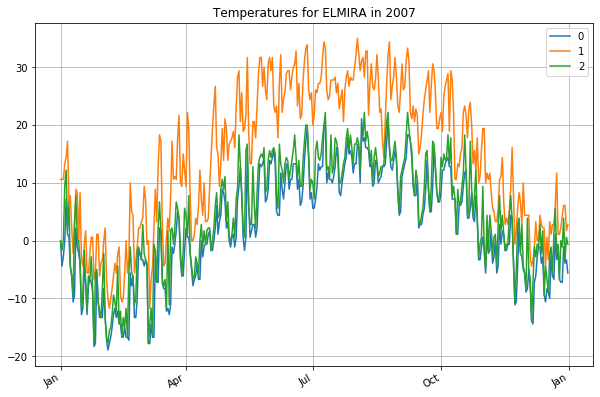

In [28]:
from lib.YearPlotter import YearPlotter
T=np.stack([_tmin,_tmax,_tobs])

fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(stat,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [29]:
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

NameError: name 'STAT' is not defined

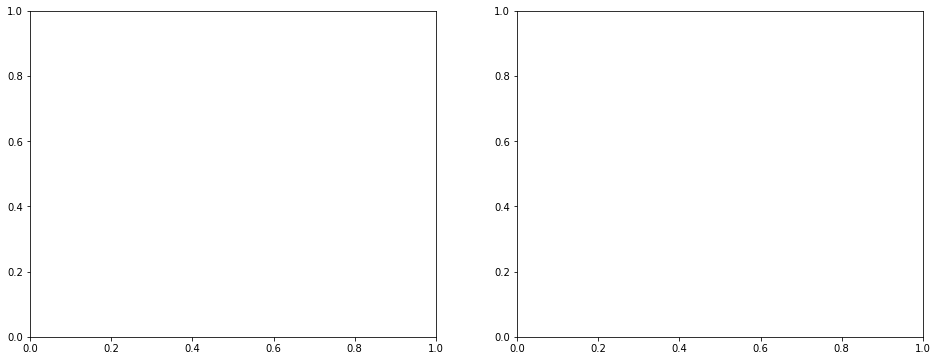

In [30]:
plot_pair(['TMIN','TMAX'],plot_valid)

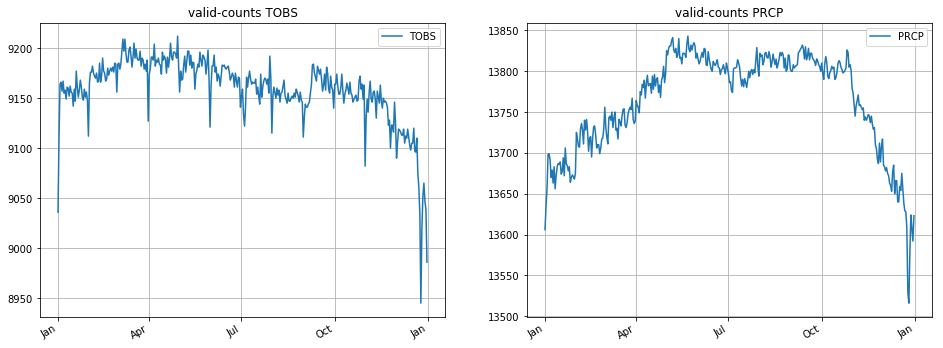

In [27]:
plot_pair(['TOBS','PRCP'],plot_valid)

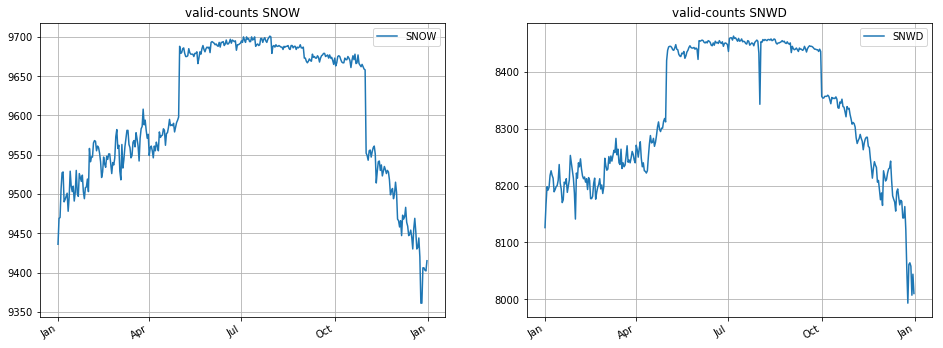

In [28]:
# Note that for "SNOW" there are more missing measurements in the summer
# While for SNWD there are less missing in the summer
# Question: do these anomalies involve the same stations?
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [29]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS','TMIN_s20','TMAX_s20','TOBS_s20']
    percipitation=['PRCP','SNOW','SNWD','PRCP_s20','SNOW_s20','SNWD_s20']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



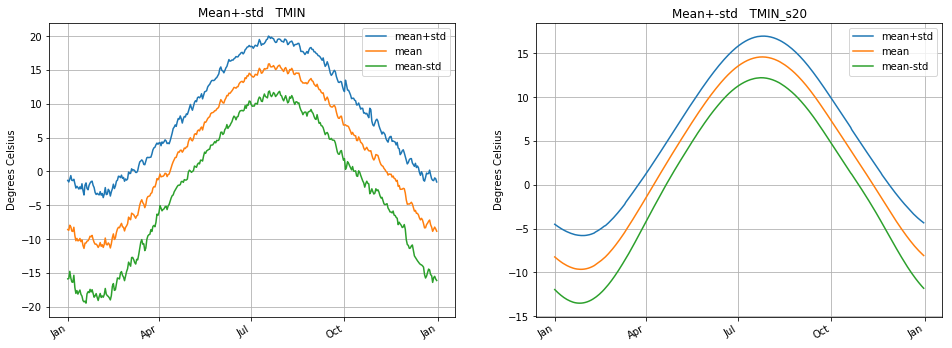

In [30]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

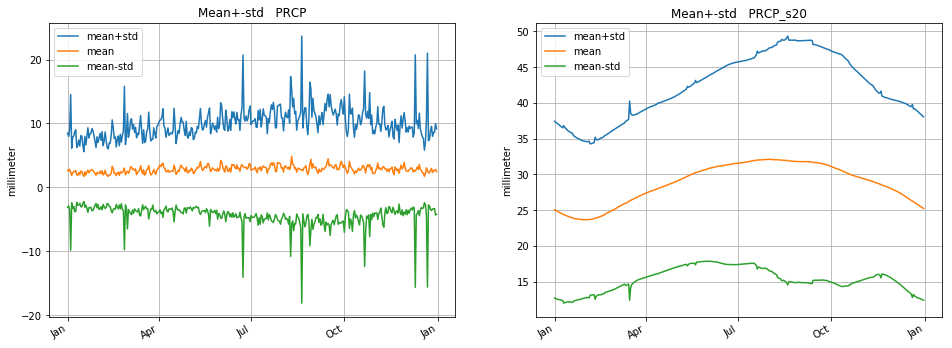

In [31]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

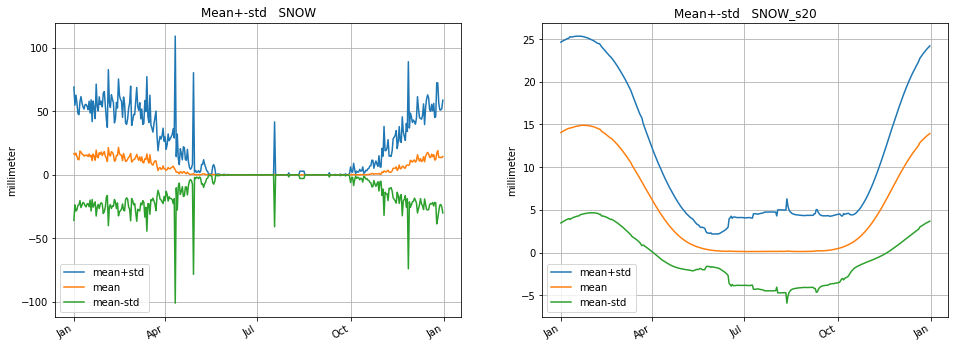

In [32]:
plot_pair(['SNOW', 'SNOW_s20'],plot_mean_std)

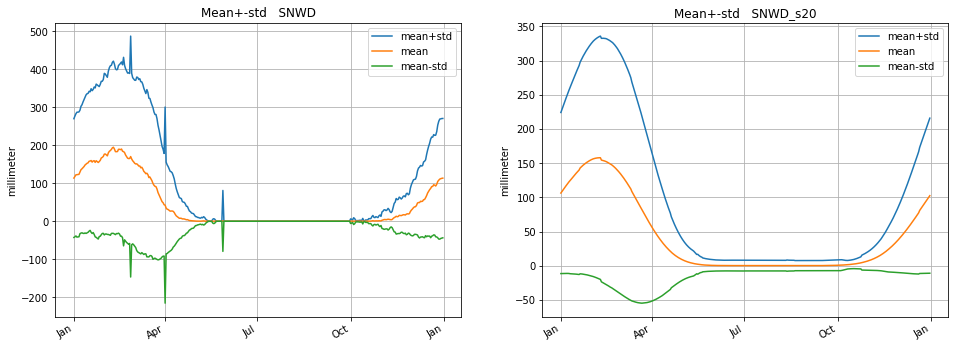

In [33]:
plot_pair(['SNWD', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [34]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [35]:
# create a subdirectory in which to place the plots.
%mkdir -p r_figures

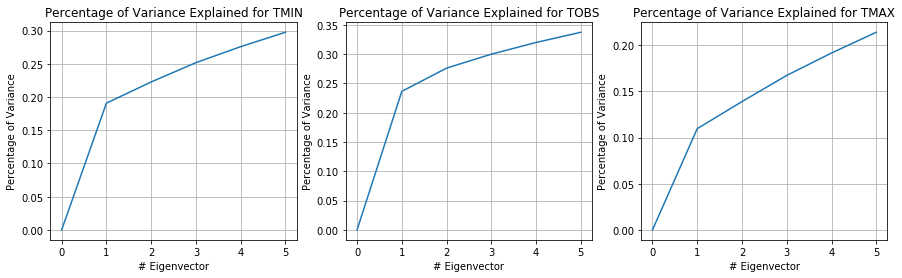

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

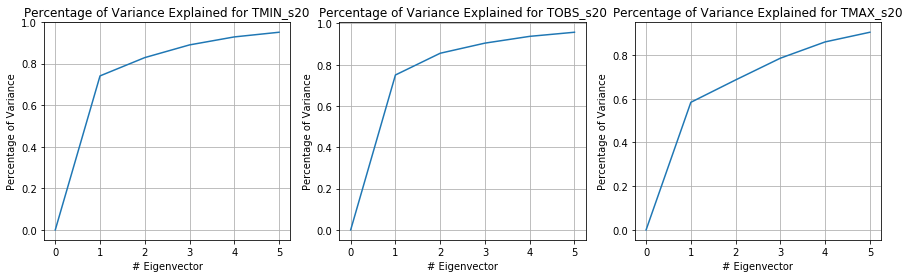

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: 
    pltVarExplained(j) 
    j+=1

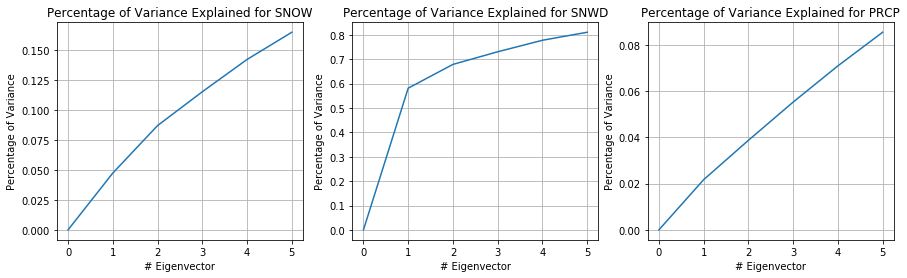

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

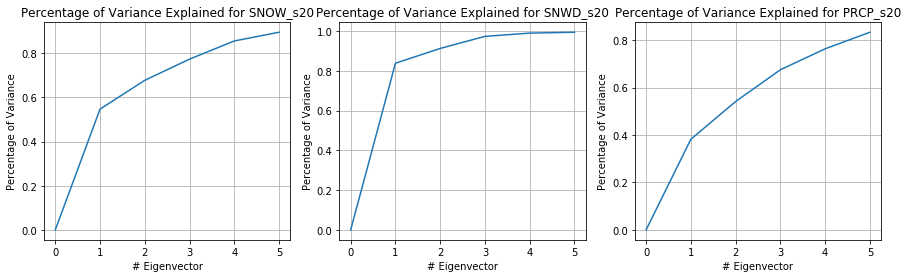

In [39]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 

### plotting top 3 eigenvectors

In [40]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

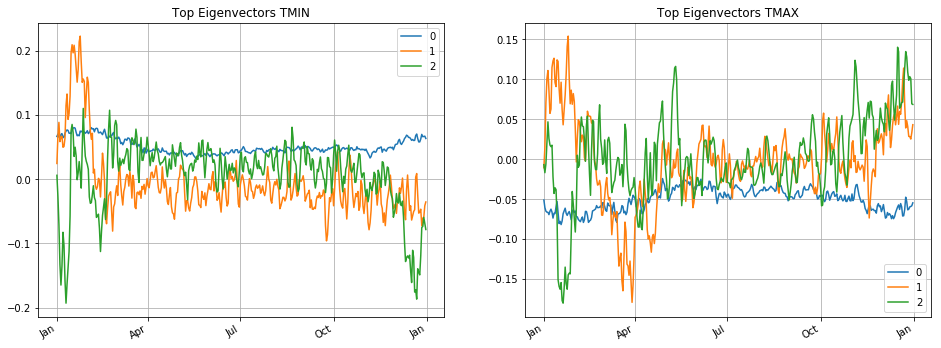

In [41]:
plot_pair(['TMIN','TMAX'],plot_eigen)

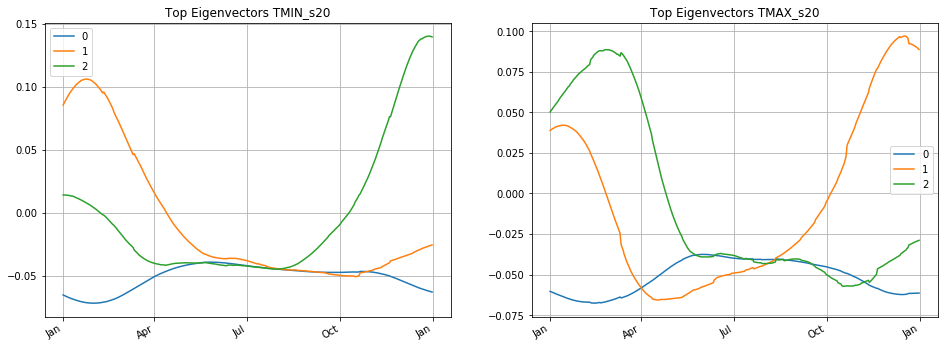

In [42]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

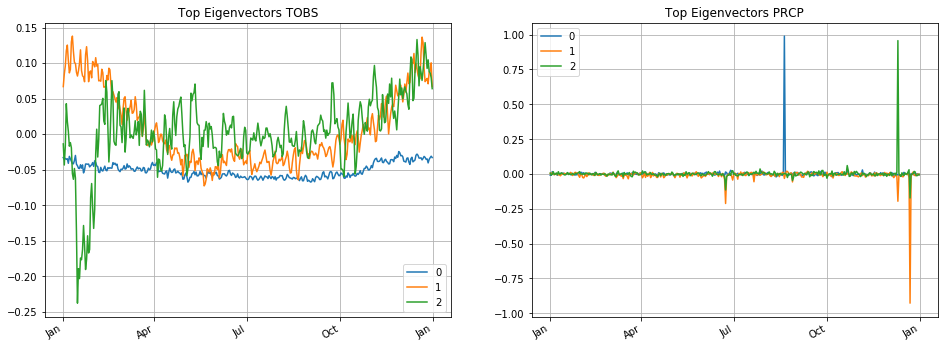

In [43]:
plot_pair(['TOBS','PRCP'],plot_eigen)

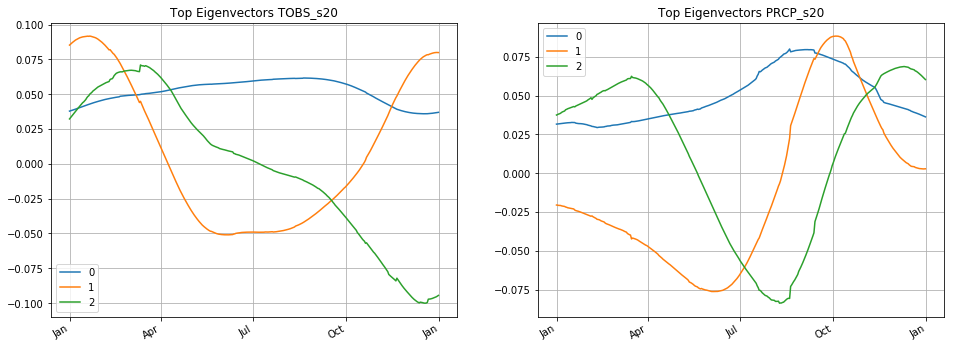

In [44]:
plot_pair(['TOBS_s20','PRCP_s20'],plot_eigen)

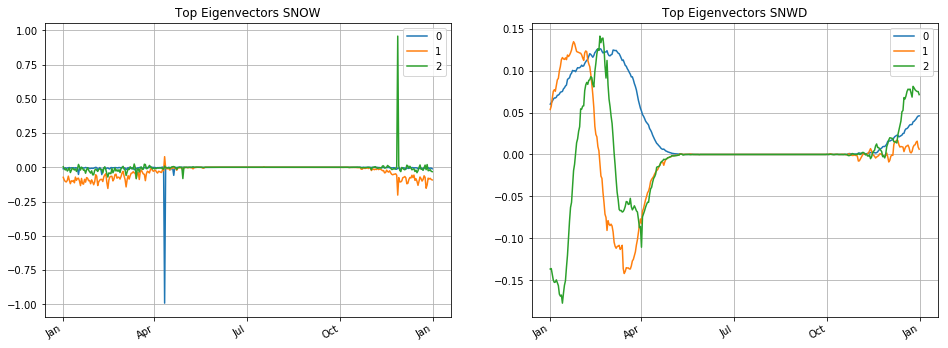

In [45]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

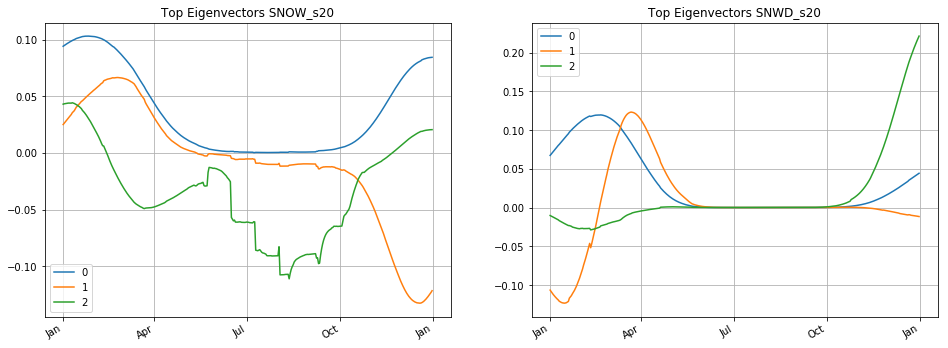

In [46]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of cariance explained by top eigen-vectors.
* The top eigen-vectors